In [3]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from pathlib import Path
import jax
import jax.numpy as jnp
import math

In [7]:
logs_base_path = "../../logs/"

experiment_names = ["mnist-64", "mnist-128"]

min_dots = math.inf 
max_dots = -math.inf 

for experiment_name in experiment_names:
  checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")

  with open(checkpoint_dir, "r") as json_file:
    df = pd.read_json(json_file)

  max_dots = max(max_dots, max(df["dots"]))
  min_dots = min(min_dots, min(df["dots"]))

FileNotFoundError: [Errno 2] No such file or directory: '../../logs/results/div-alternate-trained.json'

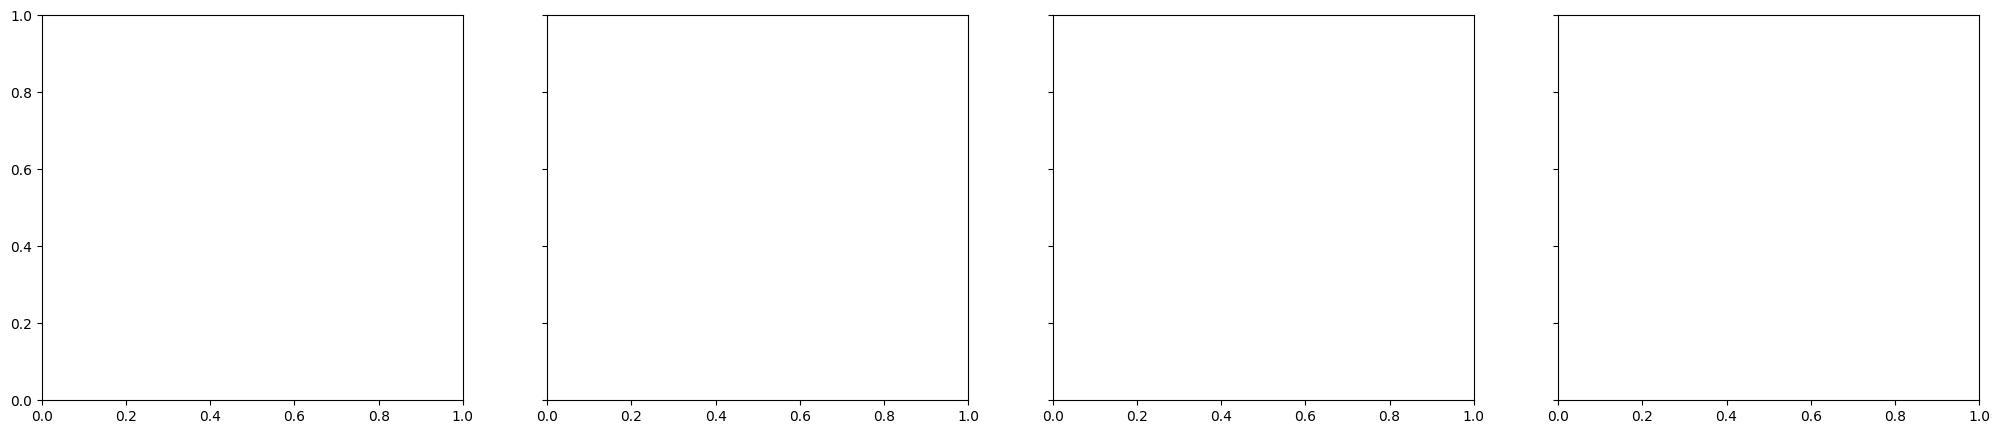

In [9]:
logs_base_path = "../../logs/"
num_experiments = len(experiment_names)

fig, axs = plt.subplots(1, num_experiments, figsize=(5 + num_experiments * 5, 5), sharey=True)

for i, experiment_name in enumerate(experiment_names):
    
    checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")

    with open(checkpoint_dir, "r") as json_file:
        df = pd.read_json(json_file)

    df["step"] = df.index * 1000

    ax1 = axs[i]
    ax2 = ax1.twinx()

    sns.lineplot(data=df, x="step", y="training_acc", label="transformer training accuracy", ax=ax1)
    sns.lineplot(data=df, x="step", y="test_acc", label="transformer test accuracy", ax=ax1)
    sns.lineplot(data=df, x="step", y="svm_accuracy", label="kernel accuracy", ax=ax1)
    
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("accuracy")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend().set_visible(False)

    sns.lineplot(data=df, x="step", y="dots", label="DOTS", color="purple", ax=ax2)
    
    if i == len(experiment_names) - 1:
      ax2.set_ylabel("DOTS")
    else: 
      ax2.set_ylabel("")

    visual_buffer = (max_dots - min_dots) * 0.05
    ax2.set_ylim([min_dots - visual_buffer, max_dots + visual_buffer])

    lines, labels = ax1.get_legend_handles_labels() 
    lines2, labels2 = ax2.get_legend_handles_labels() 

    if i == len(experiment_names) - 1:
      ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5))
    else: 
      ax2.legend().set_visible(False)
      ax2.tick_params(axis='y', which='both', labelright=False)

    ax1.set_title(experiment_name)

fig.tight_layout()

In [7]:
s5_checkpoint_dir = Path(logs_base_path, "results", "s5.json")

with open(checkpoint_dir, "r") as json_file:
  df = pd.read_json(json_file)

print(jnp.array(df["kernel"][0]))

[[4207260.5   926567.2   886161.8  ... 1579979.4  1160899.9  1163921.9 ]
 [ 926567.2  1901744.9   412414.8  ...  861282.6   847615.5   553444.06]
 [ 886161.8   412414.8  2017606.4  ...  606726.6   596839.94  701513.5 ]
 ...
 [1579979.4   861282.6   606726.6  ... 2693215.5   950305.5  1081067.4 ]
 [1160899.9   847615.5   596839.94 ...  950305.5  3051216.8   760532.4 ]
 [1163921.9   553444.06  701513.5  ... 1081067.4   760532.4  2708633.5 ]]


2024-02-25 10:36:11.900952: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [11]:
kernel = jnp.array(df["kernel"][0])
x = jnp.linalg.matrix_rank(kernel)
int(jax.device_get(x))

512